<div class="alert alert-block alert-success">
<b>Kernel Author:</b>  <br>
<a href="https://bhishanpdl.github.io/" , target="_blank">Bhishan Poudel, Ph.D Astrophysics</a> .
</div>

<a id="data-desc"></a>

<h1> Modelling Customer Churn using LightGBM</h1>

<a href="#top" class="btn btn-primary btn-sm" role="button" aria-pressed="true" style="color:white" data-toggle="popover" title="go to TOC">Go to Top</a>

References
- [Github: microsoft/LightGBM](https://github.com/microsoft/LightGBM)
- [Github: lgb usage example](https://github.com/Microsoft/LightGBM/blob/master/examples/python-guide/advanced_example.py)
- [lightgbm parameters](https://lightgbm.readthedocs.io/en/latest/Parameters.html)


In [1]:
%%javascript
IPython.OutputArea.auto_scroll_threshold = 9999;

<IPython.core.display.Javascript object>

<a id="lib"></a>

<h1> Load the libraries </h1>

<a href="#top" class="btn btn-primary btn-sm" role="button" aria-pressed="true" style="color:white" data-toggle="popover" title="go to TOC">Go to Top</a>

In [2]:
import time

time_start_notebook = time.time()

## Colab

In [3]:
%%capture
import sys
ENV_COLAB = 'google.colab' in sys.modules

if ENV_COLAB:
    # usual imports
    !pip install watermark
    !pip install scikit-plot
    !pip install catboost

    # HPO
    !git clone https://github.com/thuijskens/scikit-hyperband.git
    sys.path.append('scikit-hyperband/hyperband')

    print('Environment: Google Colab')

In [4]:
import numpy as np
import pandas as pd
import seaborn as sns
import os,sys,time
import matplotlib.pyplot as plt
import joblib
from tqdm import tqdm, trange
import plotly_express as px

# modelling
import sklearn.metrics as skmetrics
from sklearn.model_selection import StratifiedKFold

# boosting
import xgboost as xgb
import lightgbm as lgb
import catboost as cb
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

# settings
sns.set()
SEED = 100
pd.set_option('max_columns',100)
pd.set_option('max_colwidth',200)
pd.set_option('plotting.backend','matplotlib') # matplotlib, bokeh, altair, plotly

%matplotlib inline
%load_ext watermark
%watermark -iv

xgboost        1.2.0
autopep8       1.5.2
json           2.0.9
lightgbm       2.3.1
catboost       0.23.2
pandas         1.1.4
seaborn        0.11.0
plotly_express 0.4.1
joblib         0.17.0
numpy          1.19.4



<a id="useful" ></a>

<h1> Useful Scripts </h1> 

<a href="#top" class="btn btn-primary btn-sm" role="button" aria-pressed="true" style="color:white" data-toggle="popover" title="go to TOC">Go to Top</a>

In [5]:
def show_methods(obj, ncols=4,contains=None):
    lst = [i for i in dir(obj) if i[0]!='_' ]
    if contains is not None:
        lst = [i for i in lst if contains in i]
    df = pd.DataFrame(np.array_split(lst,ncols)).T.fillna('')
    return df

In [6]:
def model_eval_bin(model_name,ytest,ypreds,yprobs2d,show_plots=True):
    import sklearn.metrics as skmetrics
    import scikitplot.metrics as skpmetrics
    import os

    acc       = skmetrics.accuracy_score(ytest,ypreds)
    precision = skmetrics.precision_score(ytest,ypreds)
    recall    = skmetrics.recall_score(ytest,ypreds)
    f1        = skmetrics.f1_score(ytest,ypreds)
    auc       = skmetrics.roc_auc_score(ytest,ypreds)

    print(skmetrics.classification_report(ytest,ypreds))
    print(skmetrics.confusion_matrix(ytest,ypreds))

    df_res = pd.DataFrame({'Accuracy':[acc],
                          'Precision': [precision],
                          'Recall': [recall],
                          'F1-score': [f1],
                          'AUC': [auc]},index=[model_name])

    display(df_res.style.format("{:.4f}"))
    if not os.path.isdir('../outputs'):
        os.makedirs('../outputs')
    o = '.' if ENV_COLAB else '../outputs/'
    df_res.to_csv(o+f'model_{model_name}.csv',index=True)

    if show_plots:
        skpmetrics.plot_precision_recall(ytest,yprobs2d) # more focus on minority
        skpmetrics.plot_roc(ytest,yprobs2d) # equal focus on both groups
        skpmetrics.plot_confusion_matrix(ytest,ypreds)

In [7]:
def get_profit(y_true, y_pred):
    tn, fp, fn, tp = skmetrics.confusion_matrix(y_true,y_pred).ravel()
    profit = 400*tp - 200*fn - 100*fp
    return profit

scoring = skmetrics.make_scorer(get_profit, greater_is_better=True)

<a id="load-data" ></a>

<h1> Load the Data </h1> 

<a href="#top" class="btn btn-primary btn-sm" role="button" aria-pressed="true" style="color:white" data-toggle="popover" title="go to TOC">Go to Top</a>

In [8]:
path_data_train = '../data/raw/train.csv'
path_data_test = '../data/raw/test.csv'

if ENV_COLAB:
    path_data_train = 'https://raw.githubusercontent.com/bhishanpdl/Datasets/master/Projects/Telco_Customer_Churn/raw/train.csv'
    path_data_test = 'https://raw.githubusercontent.com/bhishanpdl/Datasets/master/Projects/Telco_Customer_Churn/raw/test.csv'

In [9]:
df_train = pd.read_csv(path_data_train)
df_test = pd.read_csv(path_data_test)

print(df_train.shape)
print(df_test.shape)
df_train.head(2).append(df_train.tail(2))

(5634, 21)
(1409, 21)


customerID  gender  SeniorCitizen Partner Dependents  tenure  \
0     1621-YNCJH  Female              0     Yes         No      36   
1     7143-BQIBA    Male              0      No         No      10   
5632  0862-PRCBS  Female              0     Yes        Yes      68   
5633  4656-CAURT    Male              0      No         No      69   

     PhoneService MultipleLines InternetService       OnlineSecurity  \
0             Yes           Yes     Fiber optic                  Yes   
1             Yes            No             DSL                  Yes   
5632          Yes           Yes     Fiber optic                   No   
5633          Yes           Yes              No  No internet service   

             OnlineBackup     DeviceProtection          TechSupport  \
0                     Yes                  Yes                  Yes   
1                      No                   No                  Yes   
5632                  Yes                   No                  Yes   
5633  No internet service  No internet service  No internet service   

              StreamingTV      StreamingMovies        Contract  \
0                      No                  Yes        Two year   
1                     Yes                   No  Month-to-month   
5632                  Yes                  Yes        Two year   
5633  No internet service  No internet service        Two year   

     PaperlessBilling              PaymentMethod  MonthlyCharges TotalCharges  \
0                 Yes    Credit card (automatic)          106.05       3834.4   
1                  No  Bank transfer (automatic)           62.25       612.95   
5632              Yes    Credit card (automatic)          103.75      7039.45   
5633               No  Bank transfer (automatic)           23.95       1713.1   

     Churn  
0       No  
1       No  
5632    No  
5633    No

In [10]:
target_name = 'Churn'

<a id="eda" ></a>

<h1> Data Processing  </h1> 

<a href="#top" class="btn btn-primary btn-sm" role="button" aria-pressed="true" style="color:white" data-toggle="popover" title="go to TOC">Go to Top</a>

In [11]:
px.histogram(df_train, x=target_name,height=300,width=300)

In [12]:
px.histogram(df_train, x='gender', color=target_name,height=300,width=300)

# Data Processing

In [13]:
sys.path.append('../src')
import util

from sklearn.model_selection import train_test_split

In [14]:
df_train = util.clean_data(df_train)
df_test = util.clean_data(df_test)

In [15]:
df_train.head(2)

customerID  tenure  MonthlyCharges  TotalCharges Churn  \
0  1621-YNCJH      36          106.05       3834.40    No   
1  7143-BQIBA      10           62.25        612.95    No   

   Contract_TotalCharges_mean  Contract_TotalCharges_mean_diff  \
0                 3683.643192                       150.756808   
1                 1370.923131                      -757.973131   

   PaymentMethod_MonthlyCharges_mean  PaymentMethod_MonthlyCharges_mean_diff  \
0                          65.801934                               40.248066   
1                          67.564819                               -5.314819   

   MultipleLines_Ordinal  SeniorCitizen_Not_SenCit  \
0                      2                         1   
1                      1                         1   

   SeniorCitizen_SeniorCitizen  Partner_No_Partner  Partner_Partner  \
0                            0                   0                1   
1                            0                   1                0   

   Dependents_Dependents  Dependents_No_Dependents  \
0                      0                         1   
1                      0                         1   

   PaperlessBilling_No_PaperlessBill  PaperlessBilling_PaperlessBill  \
0                                  0                               1   
1                                  1                               0   

   PhoneService_No_PhoneService  PhoneService_PhoneService  \
0                             0                          1   
1                             0                          1   

   OnlineSecurity_No internet service  OnlineSecurity_No_OnlineSecurity  \
0                                   0                                 0   
1                                   0                                 0   

   OnlineSecurity_OnlineSecurity  OnlineBackup_No internet service  \
0                              1                                 0   
1                              1                                 0   

   OnlineBackup_No_OnlineBackup  OnlineBackup_OnlineBackup  \
0                             0                          1   
1                             1                          0   

   DeviceProtection_DeviceProtection  DeviceProtection_No internet service  \
0                                  1                                     0   
1                                  0                                     0   

   DeviceProtection_No_DeviceProtection  TechSupport_No internet service  \
0                                     0                                0   
1                                     1                                0   

   TechSupport_No_TechSupport  TechSupport_TechSupport  \
0                           0                        1   
1                           0                        1   

   StreamingTV_No internet service  StreamingTV_No_StreamingTV  \
0                                0                           1   
1                                0                           0   

   StreamingTV_StreamingTV  StreamingMovies_No internet service  \
0                        0                                    0   
1                        1                                    0   

   StreamingMovies_No_StreamingMov  StreamingMovies_StreamingMov  \
0                                0                             1   
1                                1                             0   

   PaymentMethod_Bank transfer (automatic)  \
0                                        0   
1                                        1   

   PaymentMethod_Credit card (automatic)  PaymentMethod_Electronic check  \
0                                      1                               0   
1                                      0                               0   

   PaymentMethod_Mailed check  Partner_Dependents_No_Partner_Dependents  \
0                           0                                         0   
1                           0                   

In [16]:
index_name = 'customerID'
target_name = 'Churn'
ser_train_ids = df_train.pop(index_name)
ser_test_ids = df_test.pop(index_name)


m = {'Yes':1, 'No':0}
ser_ytrain = df_train.pop(target_name).map(m)
ser_ytest = df_test.pop(target_name).map(m)

In [17]:
df_Xtrain_full = df_train
df_Xtest = df_test

ser_ytrain_full = ser_ytrain
ser_ytest = ser_ytest

ytrain_full = np.array(ser_ytrain_full)
ytest = np.array(ser_ytest)

In [18]:
df_Xtrain,df_Xvalid,ser_ytrain,ser_yvalid = train_test_split(
    df_Xtrain_full,ser_ytrain_full,
    random_state=SEED,
    train_size=0.8
)


ytrain = np.array(ser_ytrain).flatten()
yvalid = np.array(ser_yvalid).flatten()

<a id="" ></a>

<h1>  Modelling </h1> 

<a href="#top" class="btn btn-primary btn-sm" role="button" aria-pressed="true" style="color:white" data-toggle="popover" title="go to TOC">Go to Top</a>

```python
lgb.LGBMClassifier(
    boosting_type     = 'gbdt',
    num_leaves        = 31,
    max_depth         = -1,
    learning_rate     = 0.1,
    n_estimators      = 100,
    subsample_for_bin = 200000,
    objective         = None,
    class_weight      = None,
    min_split_gain    = 0.0,
    min_child_weight  = 0.001,
    min_child_samples = 20,
    subsample         = 1.0,
    subsample_freq    = 0,
    colsample_bytree  = 1.0,
    reg_alpha         = 0.0,
    reg_lambda        = 0.0,
    random_state      = None,
    n_jobs            = -1,
    silent            = True,
    importance_type   = 'split',
    **kwargs,
)

```

In [19]:
model_name = 'lightgbm'
hpo_name   = 'hyperopt'

In [20]:
from lightgbm import LGBMClassifier

In [21]:
metric_profit_name = 'profit'
def metric_profit(y_true, y_prob):
    y_true = np.array(y_true).astype(int)
    y_pred = np.rint(y_prob)

    profit = get_profit(y_true,y_pred)
    greater_is_better = True

    return metric_profit_name, profit, greater_is_better

In [22]:
params = dict(random_state=SEED,n_estimators=1000)
model = LGBMClassifier(**params)

model.fit(df_Xtrain,ytrain,
          eval_set=(df_Xvalid, ser_yvalid),
          eval_metric = metric_profit,
          early_stopping_rounds=20,
          verbose=0,
         )

ypreds = model.predict(df_Xtest)
yprobs2d = model.predict_proba(df_Xtest)

profit = get_profit(ytest,ypreds)
print(f'test profit = ${profit:,d}')
model_eval_bin(model_name,ytest,ypreds,yprobs2d,show_plots=False)

test profit = $30,800
              precision    recall  f1-score   support

           0       0.84      0.90      0.87      1035
           1       0.64      0.52      0.57       374

    accuracy                           0.80      1409
   macro avg       0.74      0.71      0.72      1409
weighted avg       0.79      0.80      0.79      1409

[[927 108]
 [180 194]]


In [23]:
ypreds[:5]

array([1, 0, 0, 0, 0])

# LightGBM HPO Using Hyperopt


- [github: RecoTour/Ponpare/Chapter10_GBM_reg_Recommendations](https://github.com/jrzaurin/RecoTour/blob/master/Ponpare/Chapter10_GBM_reg_Recommendations.ipynb)
- [Kaggle: Parameter Tuning in One Function with Hyperopt ](https://www.kaggle.com/bigironsphere/parameter-tuning-in-one-function-with-hyperopt)
- [Kaggle Advanced: Tutorial on hyperopt](https://www.kaggle.com/fanvacoolt/tutorial-on-hyperopt)
- [lightgbm parameters](https://lightgbm.readthedocs.io/en/latest/Parameters.html)


In [24]:
import hyperopt
from hyperopt import hp, tpe, fmin, Trials, STATUS_OK, space_eval
from hyperopt.pyll import scope
from hyperopt.pyll.stochastic import sample
from pathlib import Path

path_trials = f'../artifacts/hyperopt_trials_{model_name}.joblib'

# if Path(path_trials).exists():
#     trials = joblib.load(path_trials)
# else:
#     trials = hyperopt.Trials()

# using old trial did not work.
trials = hyperopt.Trials()

In [25]:
# show_methods(hp)

In [26]:
# https://lightgbm.readthedocs.io/en/latest/Parameters.html
space_lgb_hyperopt = {
    'learning_rate': hp.loguniform('learning_rate', np.log(0.01), np.log(1)),

    'max_depth'        : scope.int(hp.quniform('max_depth', 2, 32, 1)),
    'n_estimators'     : scope.int(hp.quniform('n_estimators', 100, 5000, 50)),
    'max_bin'          : scope.int(hp.quniform('max_bin', 8, 512, 1)),

    'min_child_samples': scope.int(hp.quniform('min_child_samples', 1, 512, 1)), # min_data_in_leaf
    'min_data_in_bin'  : scope.int(hp.quniform('min_data_in_bin', 1, 512, 1)), # default = 3
    'num_leaves'       : scope.int(hp.quniform('num_leaves', 2, 1000, 1)),
    # default num_leaves = 31 and 2**max_depth > num_leaves
    # constraint 1 < num_leaves <= 131072

    'scale_pos_weight' : hp.randint('scale_pos_weight',1,50),
    # use only one of scale_pos_weight or class_weight
    #'class_weight': hp.choice('class_weight', [None, 'balanced']),

    #'subsample_freq'   : hp.randint('subsample_freq', 0, 50),
    # WARNING: This gave me worse result, dont use this.
    # perform bagging at every k iteration. Every k-th iteration,
    # LightGBM will randomly select bagging_fraction * 100 %
    # of the data to use for the next k iterations
    #to enable bagging, bagging_fraction should be set to value
    # smaller than 1.0 as well

    'subsample'       : hp.uniform ('subsample', 0.5, 1), # bagging_fraction
    'colsample_bytree': hp.uniform('colsample_bytree',0.4, 1.0), # feature_fraction
    

    # regularization
    'reg_alpha' : hp.choice('reg_alpha', [0, hp.loguniform('reg_alpha_positive', -16, 2)]), # lambda_l1
    'reg_lambda': hp.choice('reg_lambda', [0, hp.loguniform('reg_lambda_positive', -16, 2)]), # lambda_l2

    'min_child_weight': hp.loguniform('min_child_weight', -16, 5),
    'min_split_gain'  : hp.quniform('min_split_gain', 0.1, 5, 0.01),

}

In [27]:
INT_PARAMS = ['n_estimators','num_boost_round','num_leaves',
              'max_depth','max_bin',
              'min_child_samples','min_data_in_bin','subsample_freq']

In [28]:
def lgb_objective_hyperopt_skf(params):

    global INT_PARAMS

    for int_param in INT_PARAMS:
        # make integer if exist
        if int_param in params:
            params[int_param] = int(params[int_param])
            
    # num_leaves must be smaller than 2**max_depth
    if 'num_leaves' in params.keys() and params['max_depth'] > 0:
        params['num_leaves'] = int(min(params['num_leaves'],2**params['max_depth']-1))

    # skf is more time-consuming but more stable.
    skf = StratifiedKFold(n_splits=5,random_state=SEED,shuffle=True)
    profits = []
    aucs = []
    num_best_rounds = []
    for idx_tr, idx_vd in skf.split(df_Xtrain_full, ser_ytrain_full):
        Xtr,Xvd = df_Xtrain_full.iloc[idx_tr], df_Xtrain_full.iloc[idx_vd]
        ytr,yvd = ser_ytrain_full[idx_tr], ser_ytrain_full.iloc[idx_vd]

        model = LGBMClassifier(random_state=SEED,**params)

        model.fit(Xtr, ytr,
            eval_set=[(Xvd, yvd)],
            verbose=0,
            early_stopping_rounds=100)
        
        # get best round
        e = model.evals_result_
        k0 = list(e.keys())[0]
        k1 = list(e[k0].keys())[0]
        num_best_round = len(e[k0][k1])
        num_best_rounds.append(num_best_round)

        # model predictions
        vdpreds = model.predict(Xvd)
        yvd     = yvd.to_numpy().ravel()

        auc_now = skmetrics.roc_auc_score(yvd,vdpreds)
        aucs.append(auc_now)

        profit_now = get_profit(yvd,vdpreds)
        profits.append(profit_now)

    #=============================================================
    profit         = np.mean(profits)
    profit_std     = np.std(profits)
    auc            = np.mean(aucs)
    auc_std        = np.std(aucs)
    num_best_round = np.max(num_best_rounds)
    
    # debug
    #print(f'profit : {profit:,.0f} auc : {auc:,.4f}')
    #print(params)

    # loss must be minimized, so we may need to use -ve sign.
    return {'loss'  : -profit, 'status': hyperopt.STATUS_OK,
            'profit': profit, 'profit_std': profit_std,
            'auc'   : auc,    'auc_std'   : auc_std,
            'num_best_round': num_best_round
           }

In [29]:
# NOTE: use large trails such as 5k, if we run twice,
#       it will give same answer.
N_TRIALS = 2_000
# 1k gives $86,500
# 2k gives test profit $82,700
# 5k gives test profit of 85.2k

params_best = hyperopt.fmin(fn=lgb_objective_hyperopt_skf,
            space=space_lgb_hyperopt,
            algo=tpe.suggest,
            max_evals=N_TRIALS,
            timeout= None,
            trials=trials,
            verbose=10,
            show_progressbar=True,
            rstate=np.random.RandomState(SEED)
           )

params_best =  hyperopt.space_eval(space_lgb_hyperopt, params_best)
joblib.dump(trials, path_trials)


100%|██████████| 2000/2000 [19:23<00:00,  1.72trial/s, best loss: -69420.0]


['../artifacts/hyperopt_trials_lightgbm.joblib']

In [30]:
print('\n Best parameters')
print(params_best,'\n')

print('\n Best validation results')
print(trials.best_trial['result'])
print()

# model evaluation
THRESHOLD = 0.5
best_rounds = trials.best_trial['result']['num_best_round']
# params_best['n_estimators'] = best_rounds

#============================ model eval on valid set
model = lgb.LGBMClassifier(**params_best, random_state=SEED)
model.fit(df_Xtrain, ytrain)
# vdprobs2d = model.predict_proba(df_Xvalid)
# vdpreds = np.array([1 if i[1] > THRESHOLD else 0 for i in vdprobs2d])
vdpreds = model.predict(df_Xvalid)

profit = get_profit(yvalid,vdpreds)
print(skmetrics.confusion_matrix(yvalid,vdpreds))
print(f'valid profit = ${profit:,.0f}\n')


#========================== model eval on test set
model = lgb.LGBMClassifier(**params_best, random_state=SEED)
model.fit(df_Xtrain_full, ytrain_full)

# yprobs2d = model.predict_proba(df_Xtest)
# ypreds = np.array([1 if i[1] > THRESHOLD else 0 for i in yprobs2d])
ypreds = model.predict(df_Xtest)

profit = get_profit(ytest,ypreds)
print(skmetrics.confusion_matrix(ytest,ypreds))
print(f'test profit = ${profit:,.0f}')


 Best parameters
{'colsample_bytree': 0.8757770860663306, 'learning_rate': 0.8718058384285751, 'max_bin': 71, 'max_depth': 10, 'min_child_samples': 337, 'min_child_weight': 0.0038481016662428053, 'min_data_in_bin': 196, 'min_split_gain': 3.75, 'n_estimators': 4400, 'num_leaves': 18, 'reg_alpha': 3.552634042044225e-07, 'reg_lambda': 5.754838317539429e-05, 'scale_pos_weight': 7, 'subsample': 0.6747518226204151} 


 Best validation results
{'loss': -69420.0, 'status': 'ok', 'profit': 69420.0, 'profit_std': 2168.3173199511184, 'auc': 0.7425801307326989, 'auc_std': 0.006457361688610184, 'num_best_round': 171}

[[450 373]
 [ 18 286]]
valid profit = $73,500

[[546 489]
 [ 30 344]]
test profit = $82,700


In [31]:
print(trials.best_trial['result'])

{'loss': -69420.0, 'status': 'ok', 'profit': 69420.0, 'profit_std': 2168.3173199511184, 'auc': 0.7425801307326989, 'auc_std': 0.006457361688610184, 'num_best_round': 171}


# Tune boosting type with best params
- Tuning gbdt is fast. First tune params with it and then tuen the boosting type.

In [32]:
from sklearn.model_selection import GridSearchCV

In [34]:
%%time

params_best['random_state'] = SEED
model = lgb.LGBMClassifier(**params_best)

params_grid = {'boosting': ['gbdt','rf','dart','goss']}


# Create the grid
skf = StratifiedKFold(n_splits=5,random_state=SEED,shuffle=True)
grid = GridSearchCV(model, params_grid,
                    verbose=0,
                    cv=skf,
                    scoring= skmetrics.make_scorer(get_profit, greater_is_better = True),
                    n_jobs=-1)
# Run the grid
grid.fit(df_Xtrain_full, ytrain_full)

CPU times: user 2.63 s, sys: 98.5 ms, total: 2.73 s
Wall time: 1min 9s


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=100, shuffle=True),
             estimator=LGBMClassifier(colsample_bytree=0.8757770860663306,
                                      learning_rate=0.8718058384285751,
                                      max_bin=71, max_depth=10,
                                      min_child_samples=337,
                                      min_child_weight=0.0038481016662428053,
                                      min_data_in_bin=196, min_split_gain=3.75,
                                      n_estimators=4400, num_leaves=18,
                                      random_state=100,
                                      reg_alpha=3.552634042044225e-07,
                                      reg_lambda=5.754838317539429e-05,
                                      scale_pos_weight=7,
                                      subsample=0.6747518226204151),
             n_jobs=-1, param_grid={'boosting': ['gbdt', 'rf', 'dart', 'goss']},
             s

In [35]:
# Print the best parameters found
print(grid.best_params_)
print(grid.best_score_)

{'boosting': 'gbdt'}
69340.0


In [36]:
# update params_best
params_best['boosting'] = grid.best_params_['boosting']


#============================ model eval on valid set
model = lgb.LGBMClassifier(**params_best)
model.fit(df_Xtrain, ytrain)
vdpreds = model.predict(df_Xvalid)
profit = get_profit(yvalid,vdpreds)
print(skmetrics.confusion_matrix(yvalid,vdpreds))
print(f'valid profit = ${profit:,.0f}\n')


#========================== model eval on test set
model = lgb.LGBMClassifier(**params_best)
model.fit(df_Xtrain_full, ytrain_full)
ypreds = model.predict(df_Xtest)
profit = get_profit(ytest,ypreds)
print(skmetrics.confusion_matrix(ytest,ypreds))
print(f'test profit = ${profit:,.0f}')

[[450 373]
 [ 18 286]]
valid profit = $73,500

[[546 489]
 [ 30 344]]
test profit = $82,700


<a id="" ></a>

<h1>  Model Evaluation </h1> 

<a href="#top" class="btn btn-primary btn-sm" role="button" aria-pressed="true" style="color:white" data-toggle="popover" title="go to TOC">Go to Top</a>

              precision    recall  f1-score   support

           0       0.95      0.53      0.68      1035
           1       0.41      0.92      0.57       374

    accuracy                           0.63      1409
   macro avg       0.68      0.72      0.62      1409
weighted avg       0.81      0.63      0.65      1409

[[546 489]
 [ 30 344]]


test profit       = $82,700


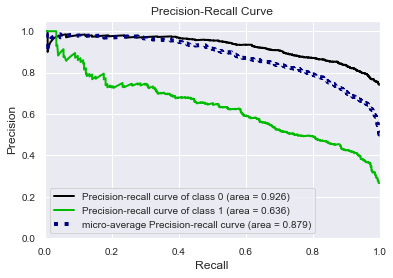

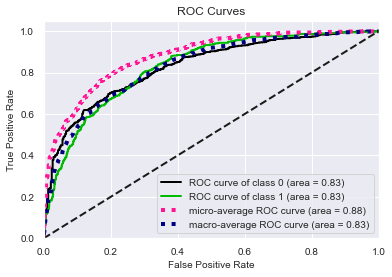

In [37]:
params_best_8300 = {'colsample_bytree': 0.707665744307114, 'learning_rate': 0.7858437768791948, 'max_bin': 248, 'max_depth': 6, 'min_child_samples': 381, 'min_child_weight': 1.65375790265872e-05, 'min_data_in_bin': 139, 'min_split_gain': 2.3000000000000003, 'n_estimators': 2200, 'num_leaves': 525, 'reg_alpha': 0, 'reg_lambda': 0, 'scale_pos_weight': 7, 'subsample': 0.7273890631561498} 
params_best_8500 = {'colsample_bytree': 0.7614216209026772, 'learning_rate': 0.816821855221229, 'max_bin': 114, 'max_depth': 27, 'min_child_samples': 411, 'min_child_weight': 2.1524026408064625e-05, 'min_data_in_bin': 71, 'min_split_gain': 3.4, 'n_estimators': 350, 'num_leaves': 466, 'reg_alpha': 7.08190801243234e-05, 'reg_lambda': 0, 'scale_pos_weight': 7, 'subsample': 0.571824428670002}
params_best_87900 = {'colsample_bytree': 0.5262112905471411, 'learning_rate': 0.5199550564232394, 'max_bin': 43, 'max_depth': 13, 'min_child_samples': 306, 'min_child_weight': 0.0019054209140305946, 'min_data_in_bin': 187, 'min_split_gain': 3.5100000000000002, 'n_estimators': 4600, 'num_leaves': 2, 'reg_alpha': 2.3316343178775068e-07, 'reg_lambda': 0, 'scale_pos_weight': 5, 'subsample': 0.7742077850067172} 

model = lgb.LGBMClassifier(**params_best)


model.fit(df_Xtrain_full,ytrain_full)
ypreds = model.predict(df_Xtest)

profit = get_profit(ytest,ypreds)
model_eval_bin(f'{model_name}+{hpo_name}',ytest,ypreds,yprobs2d,show_plots=True)
print(f"test profit       = ${profit:,d}")

# Model Interpretation

- [official: shap decision plot](https://slundberg.github.io/shap/notebooks/plots/decision_plot.html)
- [shap: decision plot](https://notebook.community/slundberg/shap/notebooks/plots/decision_plot)

In [38]:
import eli5
import warnings
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    
    display(eli5.show_weights(model))

/Users/poudel/opt/miniconda3/envs/dataSc/lib/python3.7/site-packages/sklearn/utils/deprecation.py:143: FutureWarning:

The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.

/Users/poudel/opt/miniconda3/envs/dataSc/lib/python3.7/site-packages/sklearn/utils/deprecation.py:143: FutureWarning:

The sklearn.feature_selection.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_selection. Anything that cannot be imported from sklearn.feature_selection is now part of the private API.



In [39]:
idx = 0
example = df_Xtest.iloc[idx]
answer = ser_ytest.iloc[idx]
feature_names = df_Xtest.columns.tolist()

prediction = model.predict(example.to_numpy().reshape(-1,1).T)


print(f'answer     = {answer}')
print('prediction = ', prediction[0])
print()
# print(example)
# print(feature_names)

answer     = 1
prediction =  1



In [40]:
df_Xtest.head(2)

tenure  MonthlyCharges  TotalCharges  Contract_TotalCharges_mean  \
0       1            48.6          48.6                 1362.537095   
1      56            99.9        5706.3                 3803.638602   

   Contract_TotalCharges_mean_diff  PaymentMethod_MonthlyCharges_mean  \
0                     -1313.937095                          69.049099   
1                      1902.661398                          65.642977   

   PaymentMethod_MonthlyCharges_mean_diff  MultipleLines_Ordinal  \
0                              -20.449099                      1   
1                               34.257023                      2   

   SeniorCitizen_Not_SenCit  SeniorCitizen_SeniorCitizen  Partner_No_Partner  \
0                         1                            0                   1   
1                         0                            1                   1   

   Partner_Partner  Dependents_Dependents  Dependents_No_Dependents  \
0                0                      0                         1   
1                0                      0                         1   

   PaperlessBilling_No_PaperlessBill  PaperlessBilling_PaperlessBill  \
0                                  0                               1   
1                                  0                               1   

   PhoneService_No_PhoneService  PhoneService_PhoneService  \
0                             0                          1   
1                             0                          1   

   OnlineSecurity_No internet service  OnlineSecurity_No_OnlineSecurity  \
0                                   0                                 0   
1                                   0                                 1   

   OnlineSecurity_OnlineSecurity  OnlineBackup_No internet service  \
0                              1                                 0   
1                              0                                 0   

   OnlineBackup_No_OnlineBackup  OnlineBackup_OnlineBackup  \
0                             1                          0   
1                             0                          1   

   DeviceProtection_DeviceProtection  DeviceProtection_No internet service  \
0                                  0                                     0   
1                                  1                                     0   

   DeviceProtection_No_DeviceProtection  TechSupport_No internet service  \
0                                     1                                0   
1                                     0                                0   

   TechSupport_No_TechSupport  TechSupport_TechSupport  \
0                           1                        0   
1                           0                        1   

   StreamingTV_No internet service  StreamingTV_No_StreamingTV  \
0                                0                           1   
1                                0                           0   

   StreamingTV_StreamingTV  StreamingMovies_No internet service  \
0                        0                                    0   
1                        1                                    0   

   StreamingMovies_No_StreamingMov  StreamingMovies_StreamingMov  \
0                                1                             0   
1                                1                             0   

   PaymentMethod_Bank transfer (automatic)  \
0                                        0   
1                                        1   

   PaymentMethod_Credit card (automatic)  PaymentMethod_Electronic check  \
0                                      1                               0   
1                                      0                               0   

   PaymentMethod_Mailed check  Partner_Dependents_No_Partner_Dependents  \
0                           0                                         0   
1                           0                                         0   

   Partner_Dependents_No_Partner_No_Depend

In [41]:
df_Xtest.apply(lambda x: pd.Series(x).nunique()).loc[lambda x: x>2]

tenure                                      73
MonthlyCharges                             837
TotalCharges                              1390
Contract_TotalCharges_mean                   3
Contract_TotalCharges_mean_diff           1392
PaymentMethod_MonthlyCharges_mean            4
PaymentMethod_MonthlyCharges_mean_diff    1123
MultipleLines_Ordinal                        3
dtype: int64

In [42]:
categorical_features = df_Xtest.apply(lambda x: pd.Series(x).nunique()).loc[lambda x: x<3].index.tolist()

categorical_features = categorical_features + ['MultipleLines_Ordinal']

df_Xtest[categorical_features].head(2)

SeniorCitizen_Not_SenCit  SeniorCitizen_SeniorCitizen  Partner_No_Partner  \
0                         1                            0                   1   
1                         0                            1                   1   

   Partner_Partner  Dependents_Dependents  Dependents_No_Dependents  \
0                0                      0                         1   
1                0                      0                         1   

   PaperlessBilling_No_PaperlessBill  PaperlessBilling_PaperlessBill  \
0                                  0                               1   
1                                  0                               1   

   PhoneService_No_PhoneService  PhoneService_PhoneService  \
0                             0                          1   
1                             0                          1   

   OnlineSecurity_No internet service  OnlineSecurity_No_OnlineSecurity  \
0                                   0                                 0   
1                                   0                                 1   

   OnlineSecurity_OnlineSecurity  OnlineBackup_No internet service  \
0                              1                                 0   
1                              0                                 0   

   OnlineBackup_No_OnlineBackup  OnlineBackup_OnlineBackup  \
0                             1                          0   
1                             0                          1   

   DeviceProtection_DeviceProtection  DeviceProtection_No internet service  \
0                                  0                                     0   
1                                  1                                     0   

   DeviceProtection_No_DeviceProtection  TechSupport_No internet service  \
0                                     1                                0   
1                                     0                                0   

   TechSupport_No_TechSupport  TechSupport_TechSupport  \
0                           1                        0   
1                           0                        1   

   StreamingTV_No internet service  StreamingTV_No_StreamingTV  \
0                                0                           1   
1                                0                           0   

   StreamingTV_StreamingTV  StreamingMovies_No internet service  \
0                        0                                    0   
1                        1                                    0   

   StreamingMovies_No_StreamingMov  StreamingMovies_StreamingMov  \
0                                1                             0   
1                                1                             0   

   PaymentMethod_Bank transfer (automatic)  \
0                                        0   
1                                        1   

   PaymentMethod_Credit card (automatic)  PaymentMethod_Electronic check  \
0                                      1                               0   
1                                      0                               0   

   PaymentMethod_Mailed check  Partner_Dependents_No_Partner_Dependents  \
0                           0                                         0   
1                           0                                         0   

   Partner_Dependents_No_Partner_No_Dependents  \
0                                            1   
1                                            1   

   Partner_Dependents_Partner_Dependents  \
0                                      0   
1                                      0   

   Partner_Dependents_Partner_No_Dependents  \
0                                         0   
1                                         0   

   SeniorCitizen_Dependents_Not_SenCit_Dependents  \
0                                               0   
1                                               0   

   SeniorCitizen_Dependents_Not_SenCit_No_Dependents  \
0                                      

In [43]:
import lime
import lime.lime_tabular

# categorical_features = []
categorical_features_idx = [df_Xtrain.columns.get_loc(col) 
                              for col in categorical_features]

NUM_FEATURES = len(feature_names)
explainer = lime.lime_tabular.LimeTabularExplainer(df_Xtrain.to_numpy(), 
               feature_names=feature_names, 
               class_names=['No-Churn','Churn'], 
               mode='classification')

exp = explainer.explain_instance(example, model.predict_proba,
                                 num_features=20)
exp.show_in_notebook(show_table=True)

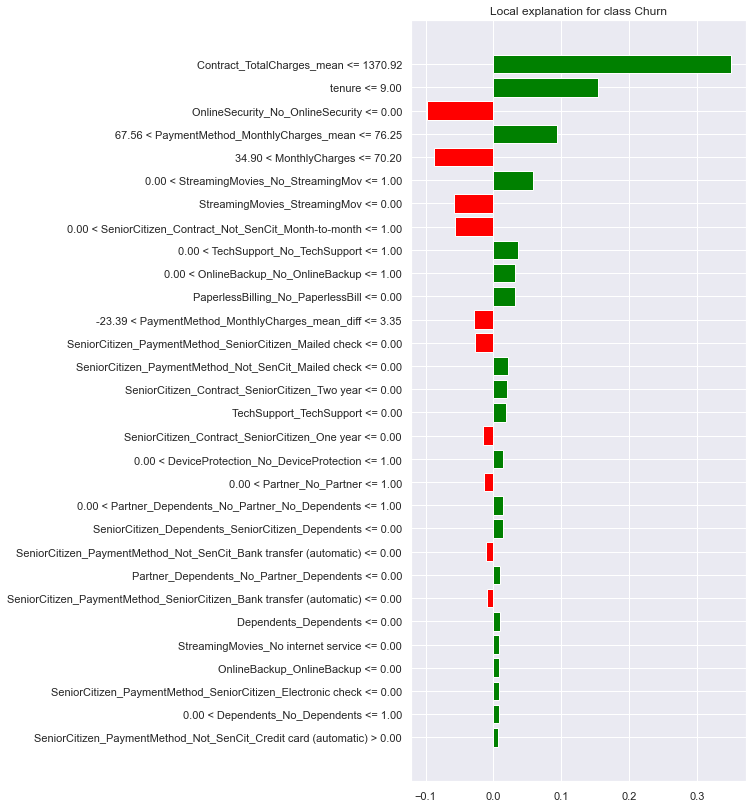

In [44]:
exp = explainer.explain_instance(example, model.predict_proba,
                                 num_features=30)
ax = exp.as_pyplot_figure(); # use semicolon
ax.set_figheight(14);

In [45]:
import shap

shap.initjs()

In [46]:
show_methods(shap)

0                         1                          2  \
0      AdditiveExplainer                      Tree                 force_plot   
1    BruteForceExplainer             TreeExplainer            have_matplotlib   
2          DeepExplainer  approximate_interactions            hclust_ordering   
3      GradientExplainer                  bar_plot                 image_plot   
4            ImageMasker                    common                     initjs   
5        KernelExplainer                  datasets                     kmeans   
6        LinearExplainer             decision_plot                 matplotlib   
7     PartitionExplainer           dependence_plot            monitoring_plot   
8   PermutationExplainer            embedding_plot  multioutput_decision_plot   
9      SamplingExplainer                explainers                      other   
10           TokenMasker                                                        

                          3  
0   partial_dependence_plot  
1            partition_tree  
2                     plots  
3                    sample  
4                 save_html  
5              summary_plot  
6                 text_plot  
7               unsupported  
8                  warnings  
9            waterfall_plot  
10

In [47]:
%%time

explainer = shap.TreeExplainer(model)
shap_values = np.array(explainer.shap_values(df_Xtest))

CPU times: user 44 ms, sys: 6.97 ms, total: 50.9 ms
Wall time: 51.4 ms


Setting feature_perturbation = "tree_path_dependent" because no background data was given.
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


In [48]:
print(df_Xtest.shape,
      explainer.expected_value,
      type(explainer.expected_value),
      len(explainer.expected_value)
     )

(1409, 72) [-0.10132615653615543, 0.10132615653615543] <class 'list'> 2


In [49]:
# if explainer values is list and have two values, take last values

expected_value = explainer.expected_value[1]
shap_values    = shap_values[1]

In [50]:
idx = 5
shap.force_plot(expected_value,
                shap_values[idx,:],
                df_Xtest.iloc[idx,:] # this is just for giving feature names
               )

In [51]:
# many points
NUM = 100
shap.force_plot(expected_value,
                shap_values[:NUM,:],
                df_Xtest.iloc[:NUM,:] # this is just for giving feature names
               )

In [52]:
max_display = 30
shap.summary_plot(shap_values, df_Xtest, plot_type="bar",
                  max_display = max_display,plot_size=(8,16))

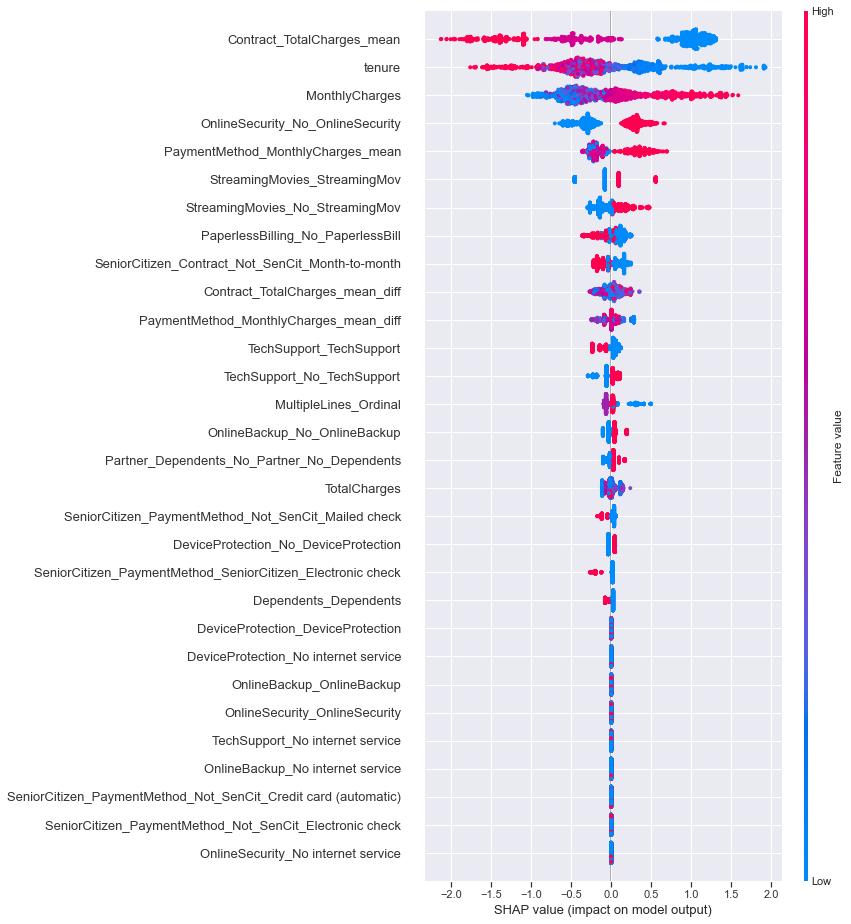

In [53]:
shap.summary_plot(shap_values,
                  df_Xtest, plot_type='dot',
                  max_display = max_display,
                 plot_size=(8,16))

In [54]:
N = 20
shap.decision_plot(expected_value,
                   shap_values[:N],
                   df_Xtest.iloc[:N])

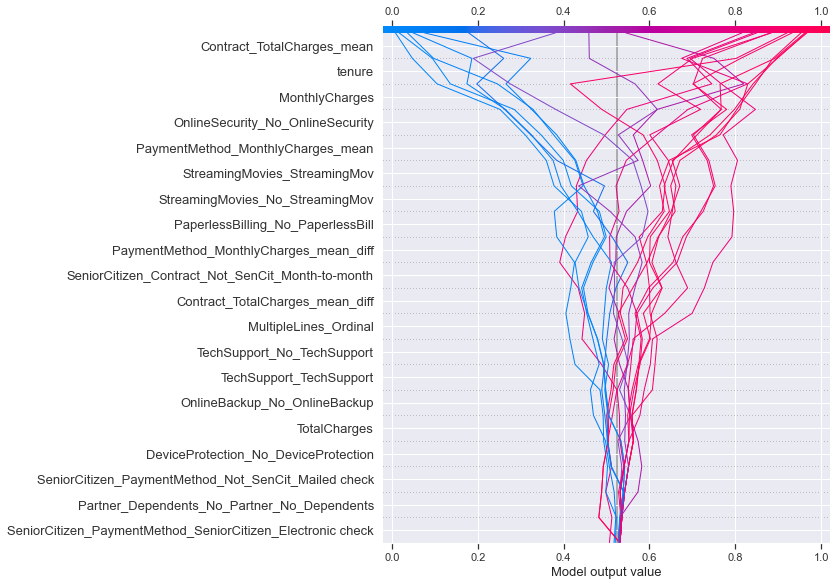

In [55]:
shap.decision_plot(expected_value,
                   shap_values[:N],
                   df_Xtest.iloc[:N],
                   link='logit'
                  )

# Analyze misclassified examples

In [56]:
print(df_Xtest.shape)
df_Xtest.head(2)

(1409, 72)


tenure  MonthlyCharges  TotalCharges  Contract_TotalCharges_mean  \
0       1            48.6          48.6                 1362.537095   
1      56            99.9        5706.3                 3803.638602   

   Contract_TotalCharges_mean_diff  PaymentMethod_MonthlyCharges_mean  \
0                     -1313.937095                          69.049099   
1                      1902.661398                          65.642977   

   PaymentMethod_MonthlyCharges_mean_diff  MultipleLines_Ordinal  \
0                              -20.449099                      1   
1                               34.257023                      2   

   SeniorCitizen_Not_SenCit  SeniorCitizen_SeniorCitizen  Partner_No_Partner  \
0                         1                            0                   1   
1                         0                            1                   1   

   Partner_Partner  Dependents_Dependents  Dependents_No_Dependents  \
0                0                      0                         1   
1                0                      0                         1   

   PaperlessBilling_No_PaperlessBill  PaperlessBilling_PaperlessBill  \
0                                  0                               1   
1                                  0                               1   

   PhoneService_No_PhoneService  PhoneService_PhoneService  \
0                             0                          1   
1                             0                          1   

   OnlineSecurity_No internet service  OnlineSecurity_No_OnlineSecurity  \
0                                   0                                 0   
1                                   0                                 1   

   OnlineSecurity_OnlineSecurity  OnlineBackup_No internet service  \
0                              1                                 0   
1                              0                                 0   

   OnlineBackup_No_OnlineBackup  OnlineBackup_OnlineBackup  \
0                             1                          0   
1                             0                          1   

   DeviceProtection_DeviceProtection  DeviceProtection_No internet service  \
0                                  0                                     0   
1                                  1                                     0   

   DeviceProtection_No_DeviceProtection  TechSupport_No internet service  \
0                                     1                                0   
1                                     0                                0   

   TechSupport_No_TechSupport  TechSupport_TechSupport  \
0                           1                        0   
1                           0                        1   

   StreamingTV_No internet service  StreamingTV_No_StreamingTV  \
0                                0                           1   
1                                0                           0   

   StreamingTV_StreamingTV  StreamingMovies_No internet service  \
0                        0                                    0   
1                        1                                    0   

   StreamingMovies_No_StreamingMov  StreamingMovies_StreamingMov  \
0                                1                             0   
1                                1                             0   

   PaymentMethod_Bank transfer (automatic)  \
0                                        0   
1                                        1   

   PaymentMethod_Credit card (automatic)  PaymentMethod_Electronic check  \
0                                      1                               0   
1                                      0                               0   

   PaymentMethod_Mailed check  Partner_Dependents_No_Partner_Dependents  \
0                           0                                         0   
1                           0                                         0   

   Partner_Dependents_No_Partner_No_Depend

In [57]:
print(ytest[:5], ypreds[:5])

[1 0 1 0 0] [1 1 1 0 0]


In [58]:
df_preds10 = pd.DataFrame({'ytest': ytest[:10],
                          'ypred': ypreds[:10]})

df_preds10['correct'] = df_preds10['ytest'] == df_preds10['ypred']

df_preds10 # two 0s are classified as 1

ytest  ypred  correct
0      1      1     True
1      0      1    False
2      1      1     True
3      0      0     True
4      0      0     True
5      0      1    False
6      1      1     True
7      0      0     True
8      0      0     True
9      1      0    False

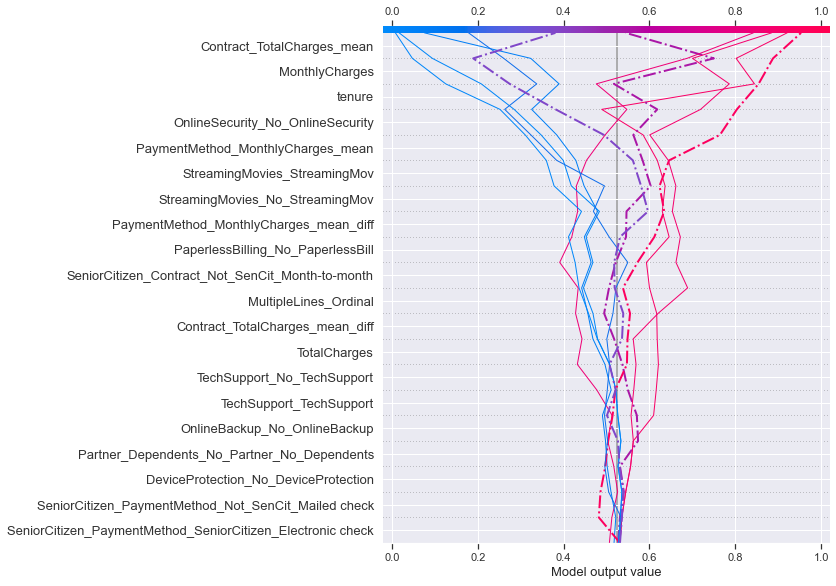

In [59]:
# shap naive cutoff point is zero log odds (probability 0.5).
N = 10

y_pred = (shap_values.sum(1) + expected_value) > 0
y_test = ytest

misclassified = y_pred[:N] != y_test[:N]

shap.decision_plot(expected_value, shap_values[:N],
                   df_Xtest.iloc[:N],
                   link='logit',
                   highlight=misclassified)

In [60]:
shap_values[:N][misclassified].shape

(3, 72)

In [61]:
df_Xtest.iloc[:N].loc[misclassified]

tenure  MonthlyCharges  TotalCharges  Contract_TotalCharges_mean  \
1      56           99.90       5706.30                 3803.638602   
5      15           91.50       1400.30                 1362.537095   
9      30           19.65        655.85                 1362.537095   

   Contract_TotalCharges_mean_diff  PaymentMethod_MonthlyCharges_mean  \
1                      1902.661398                          65.642977   
5                        37.762905                          76.285263   
9                      -706.687095                          65.642977   

   PaymentMethod_MonthlyCharges_mean_diff  MultipleLines_Ordinal  \
1                               34.257023                      2   
5                               15.214737                      1   
9                              -45.992977                      1   

   SeniorCitizen_Not_SenCit  SeniorCitizen_SeniorCitizen  Partner_No_Partner  \
1                         0                            1                   1   
5                         0                            1                   1   
9                         1                            0                   0   

   Partner_Partner  Dependents_Dependents  Dependents_No_Dependents  \
1                0                      0                         1   
5                0                      0                         1   
9                1                      0                         1   

   PaperlessBilling_No_PaperlessBill  PaperlessBilling_PaperlessBill  \
1                                  0                               1   
5                                  0                               1   
9                                  1                               0   

   PhoneService_No_PhoneService  PhoneService_PhoneService  \
1                             0                          1   
5                             0                          1   
9                             0                          1   

   OnlineSecurity_No internet service  OnlineSecurity_No_OnlineSecurity  \
1                                   0                                 1   
5                                   0                                 1   
9                                   1                                 0   

   OnlineSecurity_OnlineSecurity  OnlineBackup_No internet service  \
1                              0                                 0   
5                              0                                 0   
9                              0                                 1   

   OnlineBackup_No_OnlineBackup  OnlineBackup_OnlineBackup  \
1                             0                          1   
5                             1                          0   
9                             0                          0   

   DeviceProtection_DeviceProtection  DeviceProtection_No internet service  \
1                                  1                                     0   
5                                  0                                     0   
9                                  0                                     1   

   DeviceProtection_No_DeviceProtection  TechSupport_No internet service  \
1                                     0                                0   
5                                     1                                0   
9                                     0                                1   

   TechSupport_No_TechSupport  TechSupport_TechSupport  \
1                           0                        1   
5                           1                        0   
9                           0                        0   

   StreamingTV_No internet service  StreamingTV_No_StreamingTV  \
1                                0                           0   
5                                0                           0   
9                                1                           0   

   StreamingTV_StreamingTV  StreamingMovies_No internet servi

In [62]:
# show all misclassified only and hightlight only one.
shap.decision_plot(expected_value,
                   shap_values[:N][misclassified],
                   df_Xtest.iloc[:N].loc[misclassified],
                   link='logit',
                   highlight=0
                  )

In [ ]:
# From above find one of the misclassified index

idx_mis = 5
shap.decision_plot(expected_value,
                   shap_values[:N][idx_mis],
                   df_Xtest.iloc[:N].loc[idx_mis],
                   link='logit',
                   show=False,
                   highlight=0
                  )

plt.savefig(f"../outputs/shap_misclassified_{idx_mis}.pdf",
            format='pdf',
            dpi=1000,
            bbox_inches='tight')

In [ ]:
idx_miss = 5
shap.force_plot(expected_value,
                shap_values[idx_miss,:],
                df_Xtest.iloc[idx_miss,:],
                link='logit',
                matplotlib=False,
               )

In [ ]:
example = df_Xtest.iloc[[idx_miss]]
model.predict_proba(example)

In [ ]:
idx_miss = 5

fig = shap.force_plot(expected_value,
                shap_values[idx_miss,:],
                df_Xtest.iloc[idx_miss,:],
                link='identity', # logit did not gave me labels
                matplotlib=True,
                show=False,
                figsize=(40, 8),
               )

# plt.savefig('shap.png')
# plt.savefig("shap.pdf", format='pdf', dpi=1000,
# bbox_inches='tight')

<a id="" ></a>

<h1>  Time Taken </h1> 

<a href="#top" class="btn btn-primary btn-sm" role="button" aria-pressed="true" style="color:white" data-toggle="popover" title="go to TOC">Go to Top</a>

In [ ]:
time_taken = time.time() - time_start_notebook
h,m = divmod(time_taken,60*60)
print('Time taken to run whole notebook: {:.0f} hr '\
      '{:.0f} min {:.0f} secs'.format(h, *divmod(m,60)))